In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

In [3]:
base_dir = r'C:\Users\ROG STRIX\Documents\000000000000000 MESIN\Projek UAS PMDPM_A_Pandas\train_data'
test_data_dir = r'C:\Users\ROG STRIX\Documents\000000000000000 MESIN\Projek UAS PMDPM_A_Pandas\test_data'

img_size = 180
batch_size = 32
validation_split = 0.1
test_split = 0.1 

In [4]:
dataset = tf.keras.utils.image_dataset_from_directory(
    base_dir,
    seed=123,
    image_size=(img_size, img_size),
    batch_size=batch_size,
    validation_split=validation_split + test_split,  # 20% untuk validasi dan test
    subset="training",
    interpolation="bilinear"
)

# Pembagian lebih lanjut untuk validasi dan test (sisa dari 20%)
val_dataset = tf.keras.utils.image_dataset_from_directory(
    base_dir,
    seed=123,
    image_size=(img_size, img_size),
    batch_size=batch_size,
    validation_split=validation_split + test_split,
    subset="validation",
    interpolation="bilinear"
)

Found 300 files belonging to 3 classes.
Using 240 files for training.
Found 300 files belonging to 3 classes.
Using 60 files for validation.


In [5]:
class_names = dataset.class_names
print("Class Names:", class_names)

Class Names: ['Jeruk Lemon', 'Jeruk Nipis', 'Jeruk Sunkist']


In [6]:
AUTOTUNE = tf.data.AUTOTUNE

In [7]:
train_ds = dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

In [8]:
data_augmentation = Sequential([
    layers.RandomFlip("horizontal", input_shape=(img_size, img_size, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])

d:\anaconda3\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [9]:
def build_alexnet(input_shape=(img_size, img_size, 3)):
    model = models.Sequential([
        # Layer 1: Convolutional Layer 1
        layers.Conv2D(96, (11, 11), strides=(4, 4), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
        
        # Layer 2: Convolutional Layer 2
        layers.Conv2D(256, (5, 5), padding='same', activation='relu'),
        layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
        
        # Layer 3: Convolutional Layer 3
        layers.Conv2D(384, (3, 3), padding='same', activation='relu'),
        
        # Layer 4: Convolutional Layer 4
        layers.Conv2D(384, (3, 3), padding='same', activation='relu'),
        
        # Layer 5: Convolutional Layer 5
        layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
        
        # Flatten the output of convolutional layers
        layers.Flatten(),
        
        # Fully Connected Layer 1
        layers.Dense(4096, activation='relu'),
        layers.Dropout(0.5),
        
        # Fully Connected Layer 2
        layers.Dense(4096, activation='relu'),
        layers.Dropout(0.5),
        
        # Output Layer
        layers.Dense(len(class_names), activation='softmax')  # `len(class_names)` disesuaikan dengan jumlah kelas
    ])
    
    return model

# Bangun model AlexNet tanpa pre-trained weights
model_alexnet = build_alexnet()

# Kompilasi model
model_alexnet.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

d:\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [10]:
model_alexnet.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 43, 43, 96)     │        34,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 21, 21, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 21, 21, 256)    │       614,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 10, 10, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 10, 10, 384)    │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 10, 10, 384)    │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 10, 10, 256)    │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │        12,291 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,322,115 (142.37 MB)

 Trainable params: 37,322,115 (142.37 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, mode='max')

history = model_alexnet.fit(
    train_ds,
    epochs=30,
    validation_data=val_ds,
    callbacks=[early_stopping]
)


Epoch 1/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 401ms/step - accuracy: 0.3219 - loss: 15.6481 - val_accuracy: 0.3333 - val_loss: 1.7217
Epoch 2/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 349ms/step - accuracy: 0.4872 - loss: 2.0299 - val_accuracy: 0.7833 - val_loss: 0.5000
Epoch 3/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 346ms/step - accuracy: 0.6732 - loss: 0.8330 - val_accuracy: 0.7500 - val_loss: 0.4797
Epoch 4/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 344ms/step - accuracy: 0.7683 - loss: 0.4369 - val_accuracy: 0.9167 - val_loss: 0.2344
Epoch 5/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 342ms/step - accuracy: 0.8804 - loss: 0.3230 - val_accuracy: 0.9000 - val_loss: 0.2936
Epoch 6/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 335ms/step - accuracy: 0.8542 - loss: 0.3062 - val_accuracy: 0.8667 - val_loss: 0.4165
Epoch 7/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 336ms/step - accuracy: 0.8826 - loss: 0.2660 - val_accuracy: 0.8667 - val_loss: 0.4297


In [12]:
model_alexnet.save('BestModel_AlexNet_Pandas.h5')

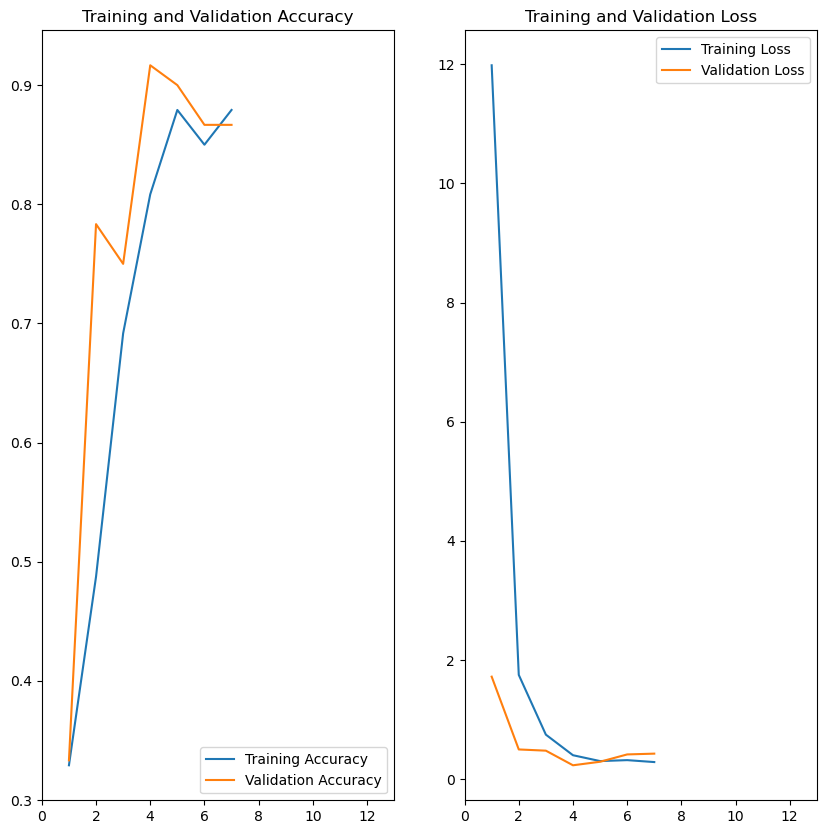

In [13]:
epochs_range = range(1, len(history.history['loss']) + 1)

plt.figure(figsize=(10, 10)) 
plt.subplot(1, 2, 1) 
plt.plot(epochs_range, history.history['accuracy'], label='Training Accuracy')  
plt.plot(epochs_range, history.history['val_accuracy'], label='Validation Accuracy') 
plt.legend(loc='lower right') 
plt.xlim(0, 13)
plt.title('Training and Validation Accuracy') 

plt.subplot(1, 2, 2)
plt.plot(epochs_range, history.history['loss'], label='Training Loss')
plt.plot(epochs_range, history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.xlim(0, 13)
plt.title('Training and Validation Loss')
plt.show()

In [14]:
def classify_images(image_path, save_path='predicted_image.jpg'):
    try:
        input_image = tf.keras.utils.load_img(image_path, target_size=(180, 180))
        input_image_array = tf.keras.utils.img_to_array(input_image)
        input_image_exp_dim = tf.expand_dims(input_image_array, 0)
        
        predictions = model_alexnet.predict(input_image_exp_dim)
        result = tf.nn.softmax(predictions[0])
        class_idx = np.argmax(result)
        confidence = np.max(result) * 100

        print(f"Prediksi: {class_names[class_idx]}")
        print(f"Confidence: {confidence:.2f}%")

        input_image = Image.open(image_path)
        input_image.save(save_path)

        return f"Prediksi: {class_names[class_idx]} dengan confidence {confidence:.2f}%. Gambar asli disimpan di {save_path}."
    except Exception as e:
        return f"Terjadi kesalahan: {e}"

# Uji prediksi pada gambar baru
result = classify_images(r'test_data/Jeruk Sunkist/jeruk_sunkist_test_3.jpeg', save_path='sunkist_2.jpg')
print(result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
Prediksi: Jeruk Sunkist
Confidence: 56.83%
Prediksi: Jeruk Sunkist dengan confidence 56.83%. Gambar asli disimpan di sunkist_2.jpg.


Found 30 files belonging to 3 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


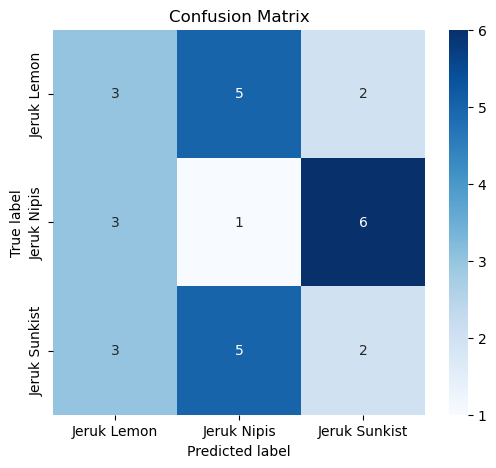

Confusion Matrix:
 [[3 5 2]
 [3 1 6]
 [3 5 2]]
Akurasi: 0.2
Presisi: [0.33333333 0.09090909 0.2       ]
Recall: [0.3 0.1 0.2]
F1 Score: [0.31578947 0.0952381  0.2       ]


In [17]:
from tensorflow.keras.models import load_model

# Muat model yang telah dilatih
model_alexnet = load_model('BestModel_AlexNet_Pandas.h5')

# Persiapkan dataset pengujian
test_data = tf.keras.preprocessing.image_dataset_from_directory(
    test_data_dir,
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(180, 180)
)

y_pred = model_alexnet.predict(test_data)
y_pred_class = tf.argmax(y_pred, axis=1)

# Menyusun true labels
true_labels = []
for _, labels in test_data:
    true_labels.extend(tf.argmax(labels, axis=1).numpy())
true_labels = tf.convert_to_tensor(true_labels)

# Matriks kebingungannya
conf_mat = tf.math.confusion_matrix(true_labels, y_pred_class)

accuracy = tf.reduce_sum(tf.linalg.diag_part(conf_mat)) / tf.reduce_sum(conf_mat)
precision = tf.linalg.diag_part(conf_mat) / tf.reduce_sum(conf_mat, axis=0)
recall = tf.linalg.diag_part(conf_mat) / tf.reduce_sum(conf_mat, axis=1)
f1_score = 2 * (precision * recall) / (precision + recall)

# Visualisasi Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_mat.numpy(), annot=True, fmt='d', cmap='Blues',
            xticklabels=["Jeruk Lemon", "Jeruk Nipis", "Jeruk Sunkist"], yticklabels=["Jeruk Lemon", "Jeruk Nipis", "Jeruk Sunkist"])
plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# Tampilkan hasil evaluasi
print("Confusion Matrix:\n", conf_mat.numpy())
print("Akurasi:", accuracy.numpy())
print("Presisi:", precision.numpy())
print("Recall:", recall.numpy())
print("F1 Score:", f1_score.numpy())